# Predict tags on StackOverflow (multilabel classification)


In [1]:
import sys
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

In [2]:
from ast import literal_eval
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [3]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [4]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [5]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

*let's it be array (.values), not pd.Series*

Size of the data:

In [6]:
print('length of: X_train: {}\nX_val: {}\nX_test: {}'.format(len(X_train), len(X_val), len(X_test)))

length of: X_train: 100000
X_val: 30000
X_test: 20000


In [7]:
y_val

array([list(['php', 'sql']), list(['javascript']),
       list(['ruby-on-rails', 'ruby']), ...,
       list(['javascript', 'forms']), list(['ruby']),
       list(['iphone', 'ios', 'objective-c', 'facebook'])], dtype=object)

### Prepare the text 

In [8]:
import re

In [9]:
# get rid of [](){}\@,;

def prepare_text(text):
    ''' 
    input: string
    return: prepared string 
    '''
    replace_by_space=re.compile('[/(){}\[\]\|@,;]')
    get_rid=re.compile('[^0-9a-z #+_]')
    stop=set(stopwords.words('english'))
    
    text=text.lower()
    # replace the brackets etc. by space
    text=replace_by_space.sub(' ',text)
    text=get_rid.sub('',text)
    text=' '.join(i for i in text.split() if i not in stop)
    return text
    

In [10]:
# sanity check

text1 = ["Mantis shrimps - don't throw the fastest PUNCHES in the ocean?",
                "How to free c++ memory vector<int> * arr?"]
text2 = ["mantis shrimps dont throw fastest punches ocean", 
               "free c++ memory vectorint arr"]

for t1, t2 in zip(text1, text2):
    if prepare_text(t1)==t2:
        print('good job')
    else: print('something has gone wrong')
        

good job
good job


In [11]:
for i in text1:
    print(prepare_text(i))
    

mantis shrimps dont throw fastest punches ocean
free c++ memory vectorint arr


#### Prepare data 

In [12]:
X_train=[prepare_text(i) for i in X_train]
X_val=[prepare_text(i) for i in X_val]
X_test=[prepare_text(i) for i in X_test]

In [13]:
y_train[:5]

array([list(['r']), list(['php', 'mysql']), list(['c#']),
       list(['javascript', 'jquery']), list(['java'])], dtype=object)

In [14]:
print('X_train: \n', X_train[:5],'\nX_val:\n', X_val[:5],'\nX_test:\n', X_test[:5])

X_train: 
 ['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app', 'get current time specific country via jquery', 'configuring tomcat use ssl'] 
X_val:
 ['odbc_exec always fail', 'access base classes variable within child class', 'contenttype application json required rails', 'sessions sinatra used pass variable', 'getting error type json exist postgresql rake db migrate'] 
X_test:
 ['warning mysql_query expects parameter 2 resource object given', 'get click coordinates input typeimage via javascript', 'implement cloud storage media assets zf', 'catcomplete jquerys autocomplete plugin', 'error building android app cordova 31 cli']


### Count the frequency (hard way)

In [15]:
from collections import defaultdict
tag_number = defaultdict(int)
word_number = defaultdict(int)

for i in X_train:
    for j in i.split():
        word_number[j]+=1

for i in y_train:
    for j in i:
        tag_number[j]+=1
        
tag_number

defaultdict(int,
            {'.net': 3872,
             'ajax': 1767,
             'algorithm': 419,
             'android': 2818,
             'angularjs': 1353,
             'apache': 441,
             'arrays': 2277,
             'asp.net': 3939,
             'asp.net-mvc': 1244,
             'c': 3119,
             'c#': 19077,
             'c++': 6469,
             'class': 509,
             'cocoa-touch': 507,
             'codeigniter': 786,
             'css': 1769,
             'csv': 435,
             'database': 740,
             'date': 560,
             'datetime': 557,
             'django': 1835,
             'dom': 400,
             'eclipse': 992,
             'entity-framework': 649,
             'excel': 443,
             'facebook': 508,
             'file': 582,
             'forms': 872,
             'function': 487,
             'generics': 420,
             'google-maps': 408,
             'hibernate': 807,
             'html': 4668,
             'html5': 842,


In [16]:
most_frequent_words=sorted(word_number.items(), key=lambda x: x[1], reverse=True)[:5]
most_frequent_tags=sorted(tag_number.items(), key=lambda x: x[1], reverse=True)[:5]

print(' 5 most common words:\n\t{}'.format([i for i, _ in most_frequent_words]))

 5 most common words:
	['using', 'php', 'java', 'file', 'javascript']


In [17]:
print('5 most common tags:\n\t{}'.format([i for i, _ in most_frequent_tags]))

5 most common tags:
	['javascript', 'c#', 'java', 'php', 'python']


## Converting text to a vector 

### Creating Bag of Words (representation of the text)

1. Create a dictionary of N-most popular words in train corpus.
2. Create a zero-vector for each title (dimension= N).
3. In each text count  words which are in the dictionary (increase by 1 the corresponding coordinate)

In [18]:
dict_size=5000
index_to_words=sorted(word_number.keys(), key=lambda x: word_number[x], reverse=True)[:dict_size]
words_to_index={i:j for j,i in enumerate(index_to_words)}
total_words=words_to_index.keys()

def bow (text, words_to_index, dict_size):
    
    word_vector=np.zeros(dict_size)
    
    for i in text.split():
        if i in words_to_index:
            word_vector[words_to_index[i]]+=1
    return word_vector
    

In [19]:
# sanity check:
test_vector={'this':0, 'wrong':1, 'group':2, 'are':3}

test_text='I think this question is directed to the wrong recipients'
bow(test_text, test_vector, 5)

array([1., 1., 0., 0., 0.])

TIme to transform the data to sparse representation (csr_matrix)

In [20]:
from scipy import sparse as sp
X_train_bow=sp.vstack([sp.csr_matrix(bow(text, words_to_index, dict_size)) for text in X_train])
X_val_bow=sp.vstack([sp.csr_matrix(bow(text, words_to_index, dict_size)) for text in X_val])
X_test_bow=sp.vstack([sp.csr_matrix(bow(text, words_to_index, dict_size)) for text in X_test])

In [21]:
print('X_train shape: {}\nX_val shape: {}\nX_test shape: {}'.format(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape))

X_train shape: (100000, 5000)
X_val shape: (30000, 5000)
X_test shape: (20000, 5000)


In [22]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

## TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

The train corpus will be used to train the vectorizer.<br>
Tresholds:5 min. occurencies, max.: 90% <br>
1-gram + 2-gram

In [24]:
X_test[:5]

['warning mysql_query expects parameter 2 resource object given',
 'get click coordinates input typeimage via javascript',
 'implement cloud storage media assets zf',
 'catcomplete jquerys autocomplete plugin',
 'error building android app cordova 31 cli']

In [25]:
def tfidf_features (X_train, X_val, X_test):
    tfidf_vectorizer=TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2), token_pattern='(\S+)')
    X_train=tfidf_vectorizer.fit_transform(X_train)
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [26]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)

In [27]:
tfidf_reversed_vocab={i:j for j,i in tfidf_vocab.items()}

In [28]:
tfidf_features(X_train, X_val, X_test)

(<100000x18300 sparse matrix of type '<class 'numpy.float64'>'
 	with 673741 stored elements in Compressed Sparse Row format>,
 <30000x18300 sparse matrix of type '<class 'numpy.float64'>'
 	with 197215 stored elements in Compressed Sparse Row format>,
 <20000x18300 sparse matrix of type '<class 'numpy.float64'>'
 	with 131034 stored elements in Compressed Sparse Row format>,
 {'draw': 4792,
  'stacked': 14941,
  'r': 12748,
  'mysql': 10394,
  'select': 14019,
  'records': 13008,
  'datetime': 4089,
  'field': 5815,
  'less': 9077,
  'specified': 14801,
  'value': 17129,
  'mysql select': 10426,
  'select records': 14054,
  'datetime field': 4093,
  'terminate': 15706,
  'windows': 17849,
  'phone': 11715,
  '81': 243,
  'app': 887,
  'windows phone': 17871,
  'phone 81': 11718,
  '81 app': 244,
  'get': 6669,
  'current': 3725,
  'time': 15887,
  'specific': 14756,
  'country': 3531,
  'via': 17419,
  'jquery': 8651,
  'get current': 6700,
  'current time': 3742,
  'time specific': 1

In [29]:
tfidf_vocab['java']

8265

In [30]:
tfidf_reversed_vocab[8265]

'java'

## MultiLabel classifier
- Possible multiple tags for 1 prediction => labels will be in binary form

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer

In [32]:
mlb = MultiLabelBinarizer(classes=sorted(tag_number.keys()))

In [33]:
y_train

array([list(['r']), list(['php', 'mysql']), list(['c#']), ...,
       list(['python', 'datetime', 'pandas']),
       list(['javascript', 'jquery']), list(['java', 'list', 'generics'])],
      dtype=object)

In [34]:
y_val

array([list(['php', 'sql']), list(['javascript']),
       list(['ruby-on-rails', 'ruby']), ...,
       list(['javascript', 'forms']), list(['ruby']),
       list(['iphone', 'ios', 'objective-c', 'facebook'])], dtype=object)

In [35]:
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [36]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition.nmf import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [37]:
def train_classifier(X_train, y_train):
    
    # LogisticRegression wraped into OneVsRestClassifier.
    clf = OneVsRestClassifier(RidgeClassifier(normalize=True))
    clf.fit(X_train, y_train)
    return clf

### Train data 

In [38]:
classifier_bow = train_classifier(X_train_bow, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

#### Predictions 

In [39]:
y_val_predicted_labels_bow = classifier_bow.predict(X_val_bow)
y_val_predicted_scores_bow = classifier_bow.decision_function(X_val_bow)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [40]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	class


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby,ruby-on-rails,ruby-on-rails-3




### Evaluation
- Accuracy
- F1-score
- Area under ROC-curve
- Area under precision-recall curve

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [42]:
def print_evaluation_scores(y_val, predicted):
    
    print(accuracy_score(y_val, predicted))
    print(f1_score(y_val, predicted, average='weighted'))
    print(average_precision_score(y_val, predicted))

In [43]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_bow)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.025133333333333334
0.4916261560519447
0.1872834479094621
Tfidf
0.2369
0.6619924452345246
0.36866075165062534


In [44]:
from metrics import roc_auc

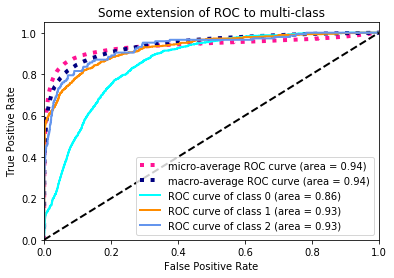

In [45]:
n_classes = len(tag_number)
roc_auc(y_val, y_val_predicted_scores_bow, n_classes)

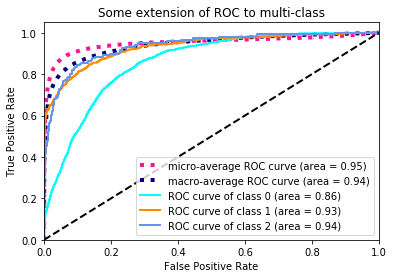

In [46]:
n_classes = len(tag_number)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [47]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))

Look for features (words or n-grams) with the largest weigths in logistic regresson model

In [48]:

def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    est = classifier.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]  # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [49]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, total_words)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, total_words)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, total_words)

Tag:	c
Top positive words:	pointer, scanf, malloc, c c++, c
Top negative words:	objective c, objective, java, python, php

Tag:	c++
Top positive words:	mfc, boost, opencv, qt, c++
Top negative words:	java, python, c#, php, javascript

Tag:	linux
Top positive words:	ubuntu, linux using, kernel space, linux c, linux
Top negative words:	run bash, c#, c unix, javascript, parent process

